<h1>Prisoner Migration Model</h1>

Tommy Flint<br>
Fall 2018

In [2]:
import random
import pylab as pl
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats, integrate
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

/Users/tommy/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<em>1. Wrangling and labelling census and crime data</em>

In [10]:
df_crime = pd.DataFrame.from_csv('data/crime_data.tsv', 
                                       sep='\t', index_col = 3, header=0)

crimes = ['P1TOT','P1VLNT','P1PRPTY', 'MURDER', 'RAPE', 'AGASSLT', 'SEXOFF', 'COMVICE']
fips = ['FIPS_ST', 'FIPS_CTY']

df_crime = df_crime[fips + crimes][df_crime.COVIND > 0]
df_crime['Id2'] = df_crime.FIPS_ST * 1000 + df_crime.FIPS_CTY

df_census = pd.DataFrame.from_csv('data/census_data.csv')
df_census['male_1844'] = df_census.male_1824 + df_census.male_2544
df_census['female_1844'] = df_census.female_1824 + df_census.female_2544
df_census['asr_1844'] = 100 * df_census.male_1844 / df_census.female_1844
df_census = df_census[['Id2','Geography',
                         'male_1864','female_1864','asr_1864',
                         'male_1844','female_1844','asr_1844']]

df_obs = pd.merge(df_crime, df_census, how = 'inner', on = 'Id2')

crimes = ['P1TOT','P1VLNT','P1PRPTY', 'MURDER', 'RAPE', 'AGASSLT', 'SEXOFF', 'COMVICE']
for crime in crimes:
    name = crime + '_rate'
    df_obs[name] = df_obs[crime] / df_obs.male_1864

df_obs['crime_rate'] = df_obs.P1TOT / df_obs.male_1864
df_obs['census_asr'] = df_obs.asr_1864 / 100

<em>2. Observed Relationship between male-to-female sex ratio and crime rate</em>

In [38]:
sns.set_style("white")
sns.set_style("ticks")

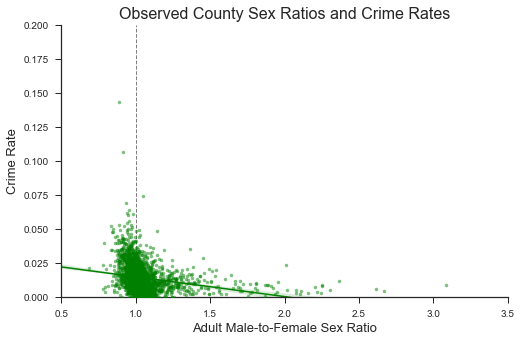

Correlation:  -0.240434709194


In [40]:
plt.figure(figsize=(8,5))

plt.ylim(0, .20)
plt.xlim(0.5, 3.5)
sns.regplot(x = df_obs.census_asr, y = df_obs.crime_rate, marker = '.', 
            color = 'green',
            line_kws = {'lw':1.5},
            scatter_kws = {'alpha' : 0.5, 'zorder' : 100})
y_ax = plt.axvline(x=1)
plt.xlabel('Adult Male-to-Female Sex Ratio', size = 13)
plt.ylabel('Crime Rate', size = 13)
plt.title('Observed County Sex Ratios and Crime Rates', size = 16)
plt.setp([y_ax], color = 'k', alpha = .5, zorder = 1, lw = 1, ls = '--')

sns.despine(offset = 0)
plt.show();

print('Correlation: ',df_obs.census_asr.corr(df_obs.crime_rate))

<em>3. Setting up the prisoner migration model</em>

In [62]:
# Function to initialize counties and crime rates
def init_counties(N, pop_mean, pop_sd, asr_mean, asr_sd, prison_pct, min_pris,
                  crime_mean, crime_sd):
    
    # County male pop, drawn from log normal distribution
    civ_men = [random.lognormvariate(pop_mean,pop_sd) for i in range(N)]
    
    # County female pop, drawn from normal dist around male pop
    civ_women = [i*random.normalvariate(1/asr_mean, asr_sd) for i in civ_men]
    
    # Initial county ASR
    civ_asr = [(x*1.0)/y for x, y in zip(civ_men, civ_women)]
    
    
    
    # Initialize prison locations (1= prison, 0=no prison)
    prison = [1 if random.random() < prison_pct and i > min_pris else 0 
              for i in civ_women]
    
    # County prisoners (men held in local county prison) set to zero
    pris_men = [0 for i in range(N)]
    
    census_asr = [(x+y)*1.0/z for x, y, z in zip(civ_men,pris_men,civ_women)]
    
    # County crime rate, drawn from log normal dist
    crime_rate = [random.lognormvariate(crime_mean,crime_sd)
        for i in range (N)]
    
    return pd.DataFrame({'civ_men' : civ_men,
                         'civ_women' : civ_women,
                         'civ_asr' : civ_asr,
                         'census_asr' : census_asr,
                         'prison' : prison,
                         'pris_men' : pris_men,
                         'crime_rate' : crime_rate
                         })

In [63]:
# Initialize counties with characteristics similar to those observed
df_ = init_counties(N = 2861, 
                   pop_mean = 9.12, pop_sd = 1.44, 
                   asr_mean = 0.986, asr_sd = 0.05, 
                   prison_pct = 0.22, min_pris = 700,
                   crime_mean = -4.3, crime_sd = 0.7)

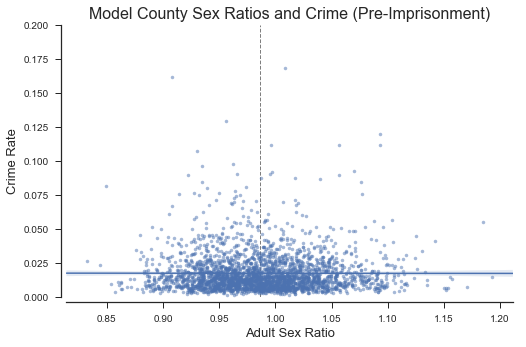

Correlation:  -0.00159010016836


In [64]:
plt.figure(figsize=(8,5))

plt.ylim(0, .2)
#plt.xlim(.5, 1.5)
sns.regplot(x = df.census_asr, y = df.crime_rate, marker = '.', 
            #color = 'k',
            line_kws = {'lw':1.5},
            scatter_kws = {'alpha' : 0.5, 'zorder' : 100})
#x_ax = plt.axhline(y=0)
y_ax = plt.axvline(x=0.986)
plt.xlabel('Adult Sex Ratio', size = 13)
plt.ylabel('Crime Rate', size = 13)
plt.title('Model County Sex Ratios and Crime (Pre-Imprisonment)', size = 16)
plt.setp([y_ax], color = 'k', alpha = .5, zorder = 1, lw = 1, ls = '--')

sns.despine(offset = 5)
plt.show();

print('Correlation: ',df.census_asr.corr(df.crime_rate))

Initially, our model counties display no correlation between sex ratio and crime rates

<em>4. Accounting for Prisoner Migration</em>

In [65]:
# Function that migrates arrested men to counties with prisons
def run_model(periods, sentence_length, inc_rate, interaction, noise):
    for t in range(periods):
        
        arrests = 'arrests_' + str(t)
                
        df['crimes'] = df.civ_men * \
        (df.crime_rate * (1 + (df.civ_asr - 1) * interaction)) * \
        random.normalvariate(1,noise)
        
        df.crimes = (df.crimes > 0) * df.crimes
        df[arrests] = df.crimes * inc_rate
        df.civ_men = df.civ_men - df[arrests]
        
        if t < sentence_length:
            df.pris_men = df.pris_men + (df.prison * (df[arrests].sum() / df.prison.sum()))

        else:
            df.pris_men = df.pris_men \
            + (df.prison * (df[arrests].sum() / df.prison.sum())) \
            - (df.prison * (df['arrests_' + str(t - sentence_length)].sum() / df.prison.sum()))
            
            df.civ_men = df.civ_men + df['arrests_' + str(t - sentence_length)]
    
        df.civ_asr = df.civ_men / df.civ_women
        df.census_asr = (df.civ_men + df.pris_men) / df.civ_women
        
    df['census_crime_rate'] = df.crimes / (df.civ_men + df.pris_men)
    df['civ_crime_rate'] = df.crimes / (df.civ_men)

In [66]:
run_model(periods = 7,
          sentence_length = 3,
          inc_rate = 0.37,
          interaction = 0,
          noise = 0)

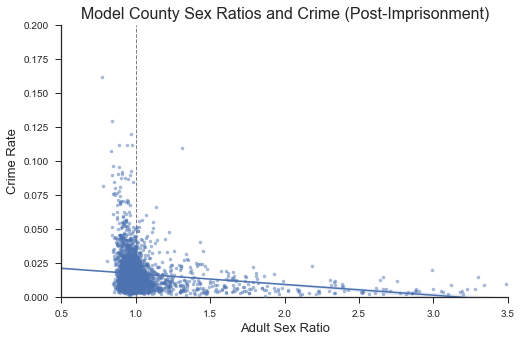

Correlation:  -0.203061644097


In [68]:
plt.figure(figsize=(8,5))

plt.ylim(0, .20)
plt.xlim(0.5, 3.5)
sns.regplot(x = df.census_asr, y = df.census_crime_rate, marker = '.', 
            #color = 'k',
            line_kws = {'lw':1.5},
            scatter_kws = {'alpha' : 0.5, 'zorder' : 100})
#x_ax = plt.axhline(y=0)
y_ax = plt.axvline(x=1)
plt.xlabel('Adult Sex Ratio', size = 13)
plt.ylabel('Crime Rate', size = 13)
plt.title('Model County Sex Ratios and Crime (Post-Imprisonment)', size = 16)
plt.setp([y_ax], color = 'k', alpha = .5, zorder = 1, lw = 1, ls = '--')

sns.despine(offset = 0)
plt.show();

print('Correlation: ',df.census_asr.corr(df.census_crime_rate))

Now, we see a highly skewed distribution and negative correlation between the sex ratio and crime rate.

Comparing our models results side-by-side with those observed:

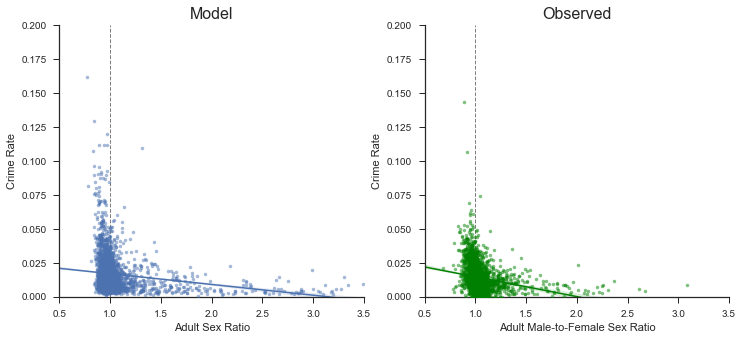

In [77]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.ylim(0, .20)
plt.xlim(0.5, 3.5)
sns.regplot(x = df.census_asr, y = df.census_crime_rate, marker = '.', 
            #color = 'k',
            line_kws = {'lw':1.5},
            scatter_kws = {'alpha' : 0.5, 'zorder' : 100})
y_ax = plt.axvline(x=1)
plt.xlabel('Adult Sex Ratio')
plt.ylabel('Crime Rate')
plt.title('Model', size = 16)
plt.setp([y_ax], color = 'k', alpha = .5, zorder = 1, lw = 1, ls = '--')
sns.despine(offset = 0)

plt.subplot(1, 2, 2)
plt.ylim(0, .20)
plt.xlim(0.5, 3.5)
sns.regplot(x = df_obs.census_asr, y = df_obs.crime_rate, marker = '.', 
            color = 'green',
            line_kws = {'lw':1.5},
            scatter_kws = {'alpha' : 0.5, 'zorder' : 100})
y_ax = plt.axvline(x=1)
plt.xlabel('Adult Male-to-Female Sex Ratio')
plt.ylabel('Crime Rate')
plt.title('Observed', size = 16)
plt.setp([y_ax], color = 'k', alpha = .5, zorder = 1, lw = 1, ls = '--')
sns.despine(offset = 0)

plt.show();

In the model, there is no causal relationship between a county's crime rate and it's sex ratio. Rather the observed correlation is entirely the product of the movement of prisoners across county lines. Counties with high crime rates have lower sex ratios because a larger portion of their men are arrested and end up in prison. Counties with prisons -- which tend to be rural and have lower crime -- have exaggeratedly high sex ratios, as they import a substantial number of imprisoned men. The resulting distribution is fairly similar to that observed in real life, suggesting that the observed relationship between county sex ratio and crime could plausibly be the result of prisoner migration, rather than the result of a causal link between sex ratio and crime.